<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-11/PSW_weekdays/PSW_with_google_mobility_weekdays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will do the same propensisty weighted methods of causal inference we have done before with google mobility dataset that only contains **weekday data**.

# 0. Go do data directory

In [1]:
cd drive/My\ Drive/covid/PSM/data

/content/drive/My Drive/covid/PSM/data


In [2]:
ls

agg_social_dist_2.csv
agg_social_dist.csv
avg_google_mobility_up_to_6_1.csv
avg_google_mobility_up_to_6_1_weekdays.csv
county_data_with_reduced_covariates_with_SIP.csv
final_data_google_and_safe_graph_up_to_6_1.csv
final_data_google_and_safe_graph_up_to_6_1_weekdays.csv
google_mobility.csv
OxCGRT_latest.csv
social_dist_aggregated_on_county.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1. load R packages into Colab

In [4]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [5]:
# for box and whisker plot
%%R
install.packages('lattice')
library(lattice)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/lattice_0.20-41.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 389631 bytes (380 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [6]:
# install package for gradient boosting machine to estimate propensity score
%%R
install.packages('twang')
library(twang)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘numDeriv’, ‘mitools’, ‘png’, ‘jpeg’, ‘gbm’, ‘survey’, ‘xtable’, ‘latticeExtra’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [7]:
%%R
install.packages('survey')
library('survey')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survey_4.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1558121 bytes (1.5 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

# 1. load/preprocess data

In [8]:
data = pd.read_csv('final_data_google_and_safe_graph_up_to_6_1_weekdays.csv')

In [9]:
data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,census_fips_code,avg_retail_and_recreation_percent_change_6_1,avg_grocery_and_pharmacy_percent_change_6_1,avg_parks_percent_change_6_1,avg_transit_stations_percent_change_6_1,avg_workplaces_percent_change_6_1,avg_residential_percent_change_6_1
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,1001.0,-6.973684,10.026316,NaN,NaN,-25.157895,9.480000
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,1003.0,-13.131579,4.697368,18.578947,-8.197368,-22.618421,7.605263
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,1005.0,3.755102,-7.763158,NaN,NaN,-15.631579,NaN
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,1007.0,1.971429,6.350000,NaN,NaN,-19.907895,NaN
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,1009.0,-5.929825,5.105263,NaN,NaN,-23.565789,8.720000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,56037.0,-10.394737,7.426230,NaN,14.578947,-23.197368,7.120000
2821,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,56039.0,-38.263158,-17.906977,-24.197368,-41.833333,-35.434211,NaN
2822,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,56041.0,1.511111,15.942857,NaN,14.842105,-19.421053,NaN
2823,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,56043.0,-4.400000,-7.000000,NaN,NaN,-20.960526,NaN


In [10]:
data.isnull().sum()

state                                              0
state_code                                         0
State Name                                         0
cnamelong                                          0
county_code                                        0
diff_in_perc_at_home                               0
SIP?                                               0
Median Household Income                            0
% Rural                                            0
Population_y                                       0
political_diff                                     0
% less than 18 years of age                        0
% 65 and over                                      0
% Asian                                            0
% Black                                            0
% Hispanic                                         0
% Non-Hispanic White                               0
census_fips_code                                   0
avg_retail_and_recreation_percent_change_6_1  

because some of the R functions expect non-null data, I can't keep null data when in my dataframe, but obviously for each column there are a unique set of dataset that doesn't contain null data in that column. For example, to analyze `avg_retail_and_recreation_percent_change_6_1` we only need to drop `249` data points, for `avg_parks_percent_change_6_1` we only need to drop `1819` data points, and so on.

I will just create 6 datasets, each one corresponding to having all non-null data for that column, and analyze those dataset separately. There might be better ways to do it in R land but I am not so familiar with R functions, so this is what I am going to do now.

In [11]:
data_retail = data.dropna(subset = ['avg_retail_and_recreation_percent_change_6_1'])
data_grocery = data.dropna(subset = ['avg_grocery_and_pharmacy_percent_change_6_1'])
data_parks = data.dropna(subset = ['avg_parks_percent_change_6_1'])
data_transit = data.dropna(subset = ['avg_transit_stations_percent_change_6_1'])
data_workplaces = data.dropna(subset = ['avg_workplaces_percent_change_6_1'])
data_residential = data.dropna(subset = ['avg_residential_percent_change_6_1'])

First need to write a function in R that encapsulates our analysis with causal inference, given a specific dataset, then we can do analysis on our 6 specific datasets by calling this function 6 times.

In [12]:
%%R
causal_analysis_on_dataset <- function(dataframe, variable) {
    logitModel <- glm(SIP.~Median.Household.Income + X..Rural +
                  political_diff+
                  X..Asian + X..Black + 
                  X..Non.Hispanic.White +
                  X..Hispanic + Population_y, data = dataframe, family = "binomial")

    # put the propensity score predicted by logistic regression
    # into a new column in the dataframe.
    dataframe$weights<-predict(logitModel, type="response")
    # convert 0, 1 to categories, as is required by the box whisker function
    dataframe$factor_SIP <- factor(dataframe$SIP.)
    box_whisker_plot = bwplot(weights~factor_SIP, data = dataframe, ylab = "propensity score", 
                              xlab = "Shelter in place?", main = 'propensity score box-whisker plot of counties with/without SIP',
                              auto.key = TRUE)
    print(box_whisker_plot)
    
    dataframe$weight_ATE <- with(dataframe, ifelse(SIP.==1, 1/weights, 1/(1-weights)))
    print(with(dataframe, by(weight_ATE, SIP., summary)))
    # deal with extreme weights
    dataframe$weight_ATE_truncated <- with(dataframe, 
                                           ifelse(weight_ATE > quantile(weight_ATE, 0.99),
                                                  quantile(weight_ATE, 0.99),
                                                  weight_ATE))
    print(with(data = dataframe, by(weight_ATE_truncated, SIP., summary)))

    covariateNames <- c('Median.Household.Income', 'X..Rural', 'political_diff',
                        'X..Asian', 'X..Black', 'X..Non.Hispanic.White', 'X..Hispanic',
                        'Population_y')
    
    # sampw has to be set here or else will not get std.eff.sz which is what we want
    # since we don't have sampling weight, we set it to 1
    balanceTable <- bal.stat(dataframe, vars = covariateNames, treat.var = 'SIP.',
                             w.all = dataframe$weight_ATE_truncated, sampw = 1,
                             get.ks = F, estimand = 'ATE', multinom = F)
    balance_results <- balanceTable$results
    round(balance_results,3)

    surveyDesignCovid <- svydesign(ids=~0, weights = ~weight_ATE_truncated,
                                   data = dataframe)
    # to obtain standard errors for propensity weighted results,
    # we need to bootstrap.
    
    # we have variable = 'avg_retail_and_recreation_percent_change_6_1',
    # but we need to make a formula of ~avg_retail_and_recreation_percent_change_6_1
    # to pass in the function below.
    formula_strings = c('~', variable)
    formula = as.formula(paste(formula_strings, collapse = ''))

    surveyDesignBoot <- as.svrepdesign(surveyDesignCovid, type=c('bootstrap'), replicates=1000)
    weightedMeans <- svyby(formula = formula, by = ~SIP., design = surveyDesignBoot,
                           FUN = svymean, covmat = TRUE)
    print(weightedMeans)
    ATE_covid <- svycontrast(weightedMeans, contrasts = c(-1,1))
    print('the effect size of having shelter in place on retail_and_recreation behavioral data')
    print(ATE_covid)
    
    # to calculate glass delta - to put effect size in standard deviations.
    weightedVars <- svyby(formula = formula, by=~SIP., design = surveyDesignBoot,
                          FUN=svyvar,covmat=TRUE)
    print('weighted Variance:')
    print(weightedVars)
    print('glass delta of effect is:')
    print(ATE_covid[[1]][[1]] / sqrt(weightedVars[[2]][[1]]))
}

# 2. causal analysis on variable `avg_retail_and_recreation_percent_change_6_1`

SIP.: 0
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.062    3.201    4.950   15.996    8.308 1193.268 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.046   1.106   1.164   1.178  24.864 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.062   3.201   4.950   6.257   8.308  14.924 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.046   1.106   1.158   1.178  14.924 
  SIP. avg_retail_and_recreation_percent_change_6_1        se
0    0                                    -11.77383 1.0059905
1    1                                    -13.72129 0.2679388
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast  -1.9475 1.0303
[1] "weighted Variance:"
  SIP.       V1        se
0    0 211.1626 34.539843
1    1 144.9521  7.122691
[1] "glass 

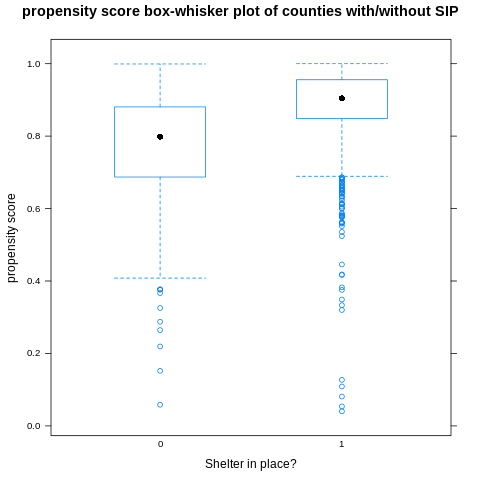

In [13]:
%%R -i data_retail
causal_analysis_on_dataset(data_retail, 'avg_retail_and_recreation_percent_change_6_1')

# 3. causal analysis on variable `avg_grocery_and_pharmacy_percent_change_6_1`

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.083   3.370   5.478  13.797   9.089 693.922 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.043   1.098   1.174   1.163  76.706 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.083   3.370   5.478   6.808   9.089  15.951 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.043   1.098   1.146   1.163  15.951 
  SIP. avg_grocery_and_pharmacy_percent_change_6_1        se
0    0                                    4.906371 0.6795453
1    1                                    1.243320 0.2209029
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast  -3.6631 0.7175
[1] "weighted Variance:"
  SIP.        V1        se
0    0 112.94056 18.450955
1    1  72.98249  4.843374
[1] "glass delta of eff

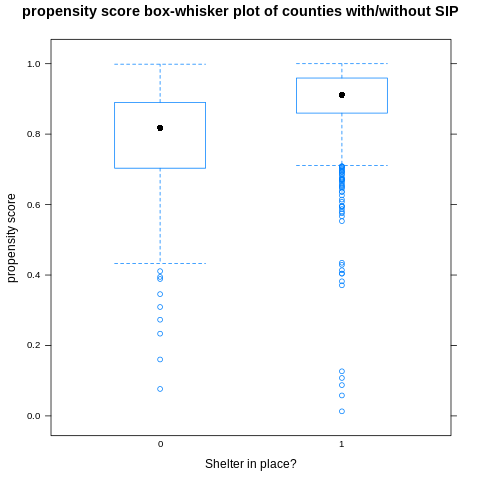

In [14]:
%%R -i data_grocery
causal_analysis_on_dataset(data_grocery, 'avg_grocery_and_pharmacy_percent_change_6_1')

# 4. causal analysis on variable `avg_parks_percent_change_6_1`

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.726   5.576   9.005  16.471  14.016 144.099 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.007   1.025   1.056   1.065   2.178 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.726   5.576   9.005   9.801  14.016  17.569 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.007   1.025   1.056   1.065   2.178 
  SIP. avg_parks_percent_change_6_1       se
0    0                    19.589257 7.106003
1    1                     5.737312 1.003055
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast  -13.852 7.1841
[1] "weighted Variance:"
  SIP.        V1       se
0    0 1612.0528 244.9469
1    1  793.1301  37.1696
[1] "glass delta of effect is:"
[1] -0.3450016


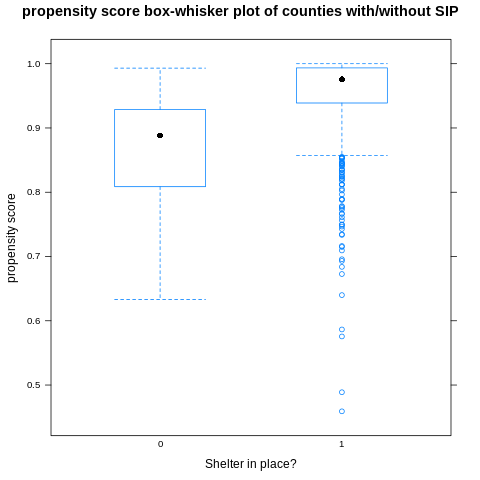

In [15]:
%%R -i data_parks
causal_analysis_on_dataset(data_parks, 'avg_parks_percent_change_6_1')

# 5. causal analysis on variable `avg_transit_stations_percent_change_6_1`

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.378   2.727   5.036  12.230   9.723 174.261 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.015   1.061   1.113   1.138   7.521 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.378   2.727   5.036   7.549   9.723  20.827 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.015   1.061   1.113   1.138   7.521 
  SIP. avg_transit_stations_percent_change_6_1        se
0    0                               -8.530171 1.4647612
1    1                              -17.287988 0.5385352
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast  -8.7578 1.5519
[1] "weighted Variance:"
  SIP.       V1       se
0    0 165.5586 28.18234
1    1 280.8789 12.73492
[1] "glass delta of effect is:"
[1] -0.68

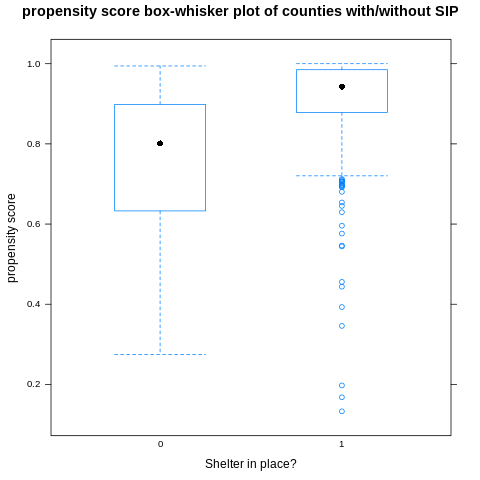

In [16]:
%%R -i data_transit
causal_analysis_on_dataset(data_transit, 'avg_transit_stations_percent_change_6_1')

# 6. causal analysis on variable `avg_workplaces_percent_change_6_1`

SIP.: 0
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.097    3.295    4.727   17.809    7.001 1777.097 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.053   1.137   1.174   1.211  24.445 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.097   3.295   4.727   5.815   7.001  15.366 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.053   1.137   1.170   1.211  15.366 
  SIP. avg_workplaces_percent_change_6_1        se
0    0                         -23.14508 0.5170806
1    1                         -26.01197 0.1610814
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast  -2.8669 0.5392
[1] "weighted Variance:"
  SIP.       V1        se
0    0 49.96671 10.592017
1    1 49.55546  2.260191
[1] "glass delta of effect is:"
[1] -0.40557

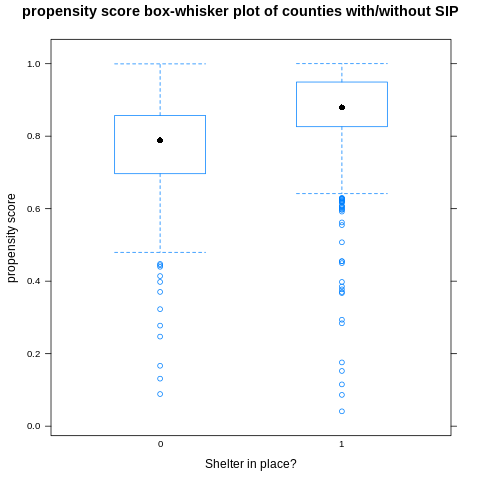

In [17]:
%%R -i data_workplaces
causal_analysis_on_dataset(data_workplaces, 'avg_workplaces_percent_change_6_1')

# 7. causal analysis on variable `avg_residential_percent_change_6_1`

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.348   3.262   6.334  14.082  12.358 209.930 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.017   1.049   1.098   1.104  13.769 
SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.348   3.262   6.334   8.872  12.358  22.402 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.017   1.049   1.098   1.104  13.769 
  SIP. avg_residential_percent_change_6_1        se
0    0                           7.353120 0.5503587
1    1                           9.272754 0.1280162
[1] "the effect size of having shelter in place on retail_and_recreation behavioral data"
         contrast     SE
contrast   1.9196 0.5629
[1] "weighted Variance:"
  SIP.       V1        se
0    0 20.18614 2.8838739
1    1 24.15017 0.9351529
[1] "glass delta of effect is:"
[1] 0.4272594


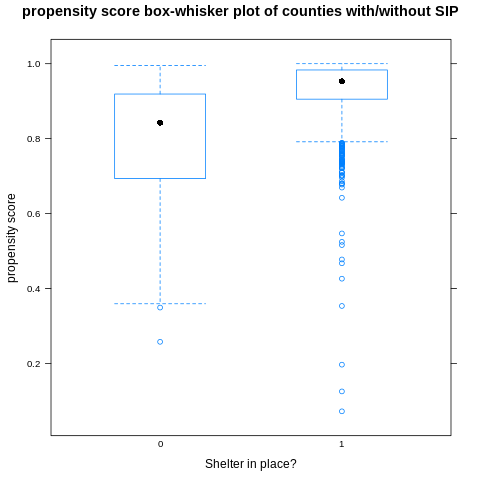

In [18]:
%%R -i data_residential
causal_analysis_on_dataset(data_residential, 'avg_residential_percent_change_6_1')

# Conclusion

We can see that comparing to the analysis with all data, the glass delta of analysis on only weekday data is slightly abnormal. Particularly, for `avg_parks_percent_change_6_1`, the contrast is `-13.8` (although with standard error of `7`)with glass delta of `-0.34`. The glass delta before is like `-0.16`.

Glass delta of residential data didn't change that much, still is `0.42`

Glass delta of transit goes from `-0.64` to `-0.68`

Glass delta of workplace goes from `-0.33` to `-0.4`.

Other glass deltas didn't change that much (To be sure the amount of contrast might have changed, but glass delta, which is that contrast over variance of the the non-treatment group effect didn't change.)